In [1]:
# !pip install git+https://github.com/XanaduAI/pennylane.git@prob_fn

In [2]:
import pennylane as qml
from variational_notebooks.entangler import get_entangler_map
from pennylane import numpy as np
from pennylane.optimize import GradientDescentOptimizer,NesterovMomentumOptimizer
from pennylane.beta import prob


from data_loader import *


In [3]:
idx_array = []
X = []
Y = []
labels = []
crops = []
sources = []
        
for idx, ((i, j), train, target, label, source, (cropX, cropY)) in enumerate(train_fashion_loader):
    
    idx_array.append((i, j))
    X.append(train.tolist())
    Y.append(target.item())
    labels.append(label.item())
    crops.append((cropX, cropY))
    
    sources.append(source)

In [35]:
shirts_inds = [i for i in range(len(labels)) if labels[i]==6]
train_inds = shirts_inds[:100]
tests_inds = shirts_inds[100:200]

X_train = [X[i] for i in train_inds]
Y_train = [Y[i] for i in train_inds]

X_test = [X[i] for i in tests_inds]
Y_test = [Y[i] for i in tests_inds]

crops_test = [crops[i] for i in tests_inds]
sources_test = [sources[i] for i in tests_inds]

In [33]:
len(Y_train),len(Y_test)

(100, 100)

In [6]:
n_wires = 9
n_qubits_readout = 8
dev = qml.device("default.qubit", wires=n_wires)

graph = get_entangler_map()

In [7]:
nb_layer_application = 3

In [8]:
# Initializing observable
# diagonal = np.array(range(2**n_qubits_readout))
# avg_observable = np.zeros((2**n_qubits_readout, 2**n_qubits_readout))
# np.fill_diagonal(avg_observable, diagonal)
bitstring_values = list(range(2**n_qubits_readout))

In [9]:
@qml.qnode(dev)
def quantum_completer(weights, x=None):
    
    for i in range(nb_layer_application):
    
        encoding(x)
        variational_circuit(weights[2*i],weights[2*i+1])

    return prob(wires=list(range(n_qubits_readout))) 

In [10]:
# feature map 
# parameters should be of the form params = np.random.uniform(size=(num_layers, num_qubits, 3))

def encoding(x):
    for wire in range(n_wires // 3):
        qml.Rot(*x[3*wire: 3*(wire+1)], wires=[wire])     #Encode three features in each qubit

In [11]:
# QAOA ansatz definition
# unitary operator U_B with parameter beta
def U_B(beta):
    for wire in range(n_wires):
        qml.RX(2 * beta, wires=wire)

# unitary operator U_C with parameter gamma
def U_C(gamma):
    for wire_pair in graph:
        qml.CNOT(wires=[wire_pair[0], wire_pair[1]])
        qml.RZ(2*gamma, wires=wire_pair[1])
        qml.CNOT(wires=[wire_pair[0], wire_pair[1]])
        
def variational_circuit(gamma,beta):

    U_C(gamma)
    U_B(beta)

In [12]:
def loss(labels, predictions):
    return np.mean([(label - prediction)**2 for label, prediction in zip(labels, predictions)])

def cost(weights, X, Y):
    predictions = [np.mean(quantum_completer(weights, x=x) * bitstring_values) / 255. for x in X]
    return loss(Y, predictions)

In [13]:
def predict(X):
    return [np.mean(quantum_completer(weights, x=x) * bitstring_values) / 255. for x in X]

In [14]:
%%time
# Define optimizer. 
opt = NesterovMomentumOptimizer(stepsize=0.4)
batch_size = 10

# Setup initial weights and number of optimization steps.
weights = np.random.random(2*nb_layer_application) 
steps = 3

# Optimizing the loss-function.
for it in range(steps):
    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, len(X_train), (batch_size,))
    X_batch = [X_train[i] for i in batch_index]
    Y_batch = [Y_train[i] for i in batch_index]
    weights = opt.step(lambda v: cost(v, X_batch, Y_batch), weights)
    
    print("Iter: {:5d} | Cost: {:0.7f} ".format(it + 1, cost(weights, X_train, Y_train)))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 57.9 µs


In [15]:
Y_hat_test = predict(X_test)

In [16]:
loss(Y_test, Y_hat_test)

0.3073781276450712

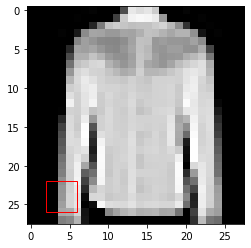

In [37]:
ind_example = 0

X_test_example = X_test[ind_example]
source_test_example = np.array(sources_test[ind_example].tolist())
cropX, cropY = crops_test[ind_example]

new_window_values = np.array(X_test_example).reshape(3, 3)
# source_test_example[cropY:cropY+3, cropX:cropX+3] = new_window_values

fig = plt.figure()
ax = fig.add_subplot(111)
rect = patches.Rectangle((cropX-1, cropY-1),4,4,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
ax.imshow(source_test_example, cmap=plt.cm.gray, vmin=0, vmax=1)
fig.savefig(f'./images/full_{idx}.png')

source_test_example[cropY:cropY+3, cropX:cropX+3] = new_window_values

fig = plt.figure()
ax = fig.add_subplot(111)
rect = patches.Rectangle((cropX-1, cropY-1),4,4,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
ax.imshow(source_test_example, cmap=plt.cm.gray, vmin=0, vmax=1)
fig.savefig(f'./images/full_{idx}_crop.png')